In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
import time

htru = pd.read_csv('datasets/HTRU_2.csv', header=None)
htru.columns = ['mean_intregrated', 'sd_integrated', 'kurtosis_integrated', 'skew_integrated','mean_dmsnr', 'sd_dmsnr', 'kurtossi_dmsnr', 'skew_dmsnr','labels']

scaling = StandardScaler()
hrtu_scaled = scaling.fit_transform(htru.drop('labels', axis=1))

random_state=42
features = hrtu_scaled
labels = htru['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=random_state)
X_train_real, X_validation, y_train_real, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)

In [4]:
htru['labels'].value_counts(0)

0    16259
1     1639
Name: labels, dtype: int64

In [5]:
1639/(16259+1639)
# VERY Imbalance data, so we need other measure other than accuracy so go next!!

0.09157447759526204

In [291]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
def get_all_metrics_score(predict_value, real_value):
    acc_scr = accuracy_score(predict_value, real_value)
    pre_scr = precision_score(predict_value, real_value)
    recall_scr = recall_score(predict_value, real_value)
#     roc_scr = roc_auc_score(predict_value, real_value)
    f1_scr = f1_score(predict_value, real_value)
    print("SCORE")
    print("Accuracy:", acc_scr)
    print("Precision:", pre_scr)
    print("Recall:", recall_scr)
    print("F1 Score:", f1_scr)
#     print("ROC AUC:", roc_scr)


In [241]:
from sklearn.metrics import homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score
def get_all_cluster_metric_score(predict_value, real_value):
    homo_scr = homogeneity_score(real_value, predict_value)
    vm_scr = v_measure_score(real_value, predict_value)
    complete_scr = completeness_score(real_value, predict_value)
    adrand_scr = adjusted_rand_score(real_value, predict_value)
    print("SCORE")
    print("Homogenity:", homo_scr)
    print("V Measure:", vm_scr)
    print("Completeness:", complete_scr)
    print("Adjusted RandIndex:", adrand_scr)


No handles with labels found to put in legend.


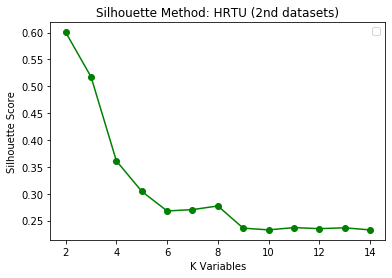

In [192]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k = 5
kmeans = KMeans(n_clusters=k, random_state=random_state)
# kmeans.(X_train)
y_pred = kmeans.fit_predict(X_train)

# y_pred
# using elbow method for choosing K Values
# using silhouette_score
# Get example score for K = 1, 11 (Optimal) and 40, 60
kmean_clfs_n = []
range_loop = range(2, 15)
for i in range_loop:
    kmean = KMeans(n_clusters=i , random_state=random_state)
    kmean.fit(X_train)
    kmean_clfs_n.append(kmean)

# Silhouette_schore
silhouette = [silhouette_score(X_train, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , silhouette, "g-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Method: HRTU (2nd datasets)')
ax.legend()
plt.show(fig)

No handles with labels found to put in legend.


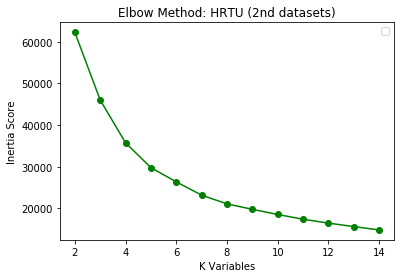

In [191]:
fig, ax = plt.subplots()
ax.plot(range_loop , inertia, "g-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Inertia Score')
ax.set_title('Elbow Method: HRTU (2nd datasets)')
ax.legend()
plt.show(fig)

In [223]:
# Try K mean = 5, based on Graph
# Does Cluster align with your label?, so we choose K according to silhouette score
# K = 2 is the highest since it cannot be distinguish by using elbow method (No elbow visually occurs!!)
from sklearn.metrics import homogeneity_score, v_measure_score, completeness_score

# Based on silhouteete score
fin_kmeans = KMeans(n_clusters=2, random_state=random_state)
y_pred_kmeans = fin_kmeans.fit_predict(X_train)

get_all_cluster_metric_score(y_pred_kmeans, y_train)

SCORE
Homogenity: 0.4314200428970589
V Measure: 0.39880116354864514
Completeness: 0.3707680688788
Adjusted RandIndex: 0.600878922735672


In [224]:
# Based on elbow method score
fin_kmeans = KMeans(n_clusters=5, random_state=random_state)
y_pred_kmeans = fin_kmeans.fit_predict(X_train)

get_all_cluster_metric_score(y_pred_kmeans, y_train)

SCORE
Homogenity: 0.5112198003053632
V Measure: 0.1961927775203037
Completeness: 0.12138943199822488
Adjusted RandIndex: 0.12374942171201953


# EM algorithm!!

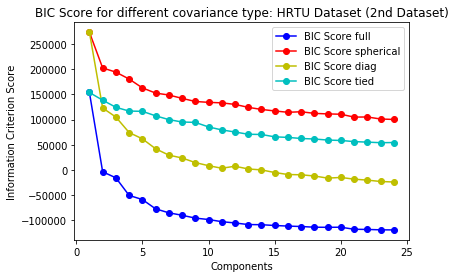

In [243]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, random_state=random_state)
gm.fit(features)

gm_clfs_n = []
range_loop = range(1, 25)
fig, ax = plt.subplots()

color = ['b-o', 'r-o', 'y-o', 'c-o', 'm-o', 'k-o']
k = 0
for i in ['full', 'spherical', 'diag', 'tied']:
    bic_score_list = []
    for j in range_loop:
        gm = GaussianMixture(n_components=j , random_state=random_state, covariance_type=i)
        gm.fit(X_train)
        bic_score = gm.bic(X_train)
        bic_score_list.append(bic_score)
    ax.plot(range_loop , bic_score_list, color[k], label=f'BIC Score {i}')
    k = k+1
    
ax.set_xlabel('Components')
ax.set_ylabel('Information Criterion Score')
ax.set_title('BIC Score for different covariance type: HRTU Dataset (2nd Dataset)')
ax.legend()
plt.show(fig)
# Silhouette_schore

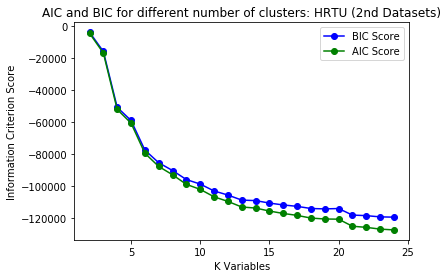

In [204]:
gm_clfs_n = []
range_loop = range(2, 25)
for i in range_loop:
#     print("K", i)
    gm = GaussianMixture(n_components=i , random_state=random_state)
    gm.fit(X_train)
    gm_clfs_n.append(gm)


bic_score = [i.bic(X_train) for i in gm_clfs_n]
aic_score = [i.aic(X_train) for i in gm_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , bic_score, "b-o", label='BIC Score')
ax.plot(range_loop , aic_score, "g-o", label='AIC Score')
ax.set_xlabel('K Variables')
ax.set_ylabel('Information Criterion Score')
ax.set_title('AIC and BIC for different number of clusters: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [283]:
gm = GaussianMixture(n_components=21, random_state=random_state)
gm.fit(features)

y_pred_gmm = gm.predict(X_train)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_gmm, y_train)

SCORE
Homogenity: 0.6995058187608012
V Measure: 0.14146495329152722
Completeness: 0.07868937131247192
Adjusted RandIndex: 0.028391187221141558


In [334]:
gm = GaussianMixture(n_components=23, random_state=random_state)
gm.fit(features)

y_pred_gmm = gm.predict(X_train)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_gmm, y_train)

SCORE
Homogenity: 0.7156668997028387
V Measure: 0.1413704057033123
Completeness: 0.07843177601268123
Adjusted RandIndex: 0.02717038337890959


## PCA 

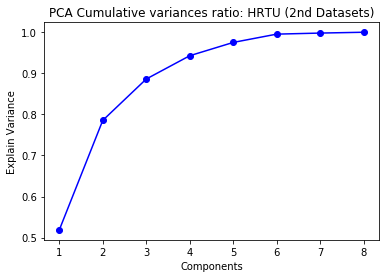

In [418]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
transformed = pca.transform(X_train)

fig, ax = plt.subplots()
ax.plot(range(1, pca.n_components_ +1) , np.cumsum(pca.explained_variance_ratio_), "b-o")
# ax.plot(range_loop , aic_score, "g-", label='AIC Score')
ax.set_xlabel('Components')
ax.set_ylabel('Explain Variance')
ax.set_title('PCA Cumulative variances ratio: HRTU (2nd Datasets)')
# ax.legend()
plt.show(fig)

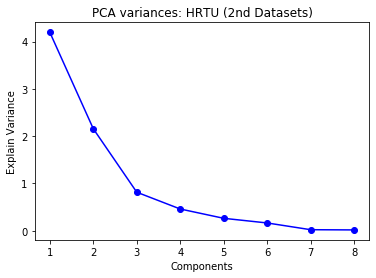

In [419]:
fig, ax = plt.subplots()
ax.plot(range(1, pca.n_components_ +1) , pca.explained_variance_, "b-o")
# ax.plot(range_loop , aic_score, "g-", label='AIC Score')
ax.set_xlabel('Components')
ax.set_ylabel('Explain Variance')
ax.set_title('PCA variances: HRTU (2nd Datasets)')
# ax.legend()
plt.show(fig)

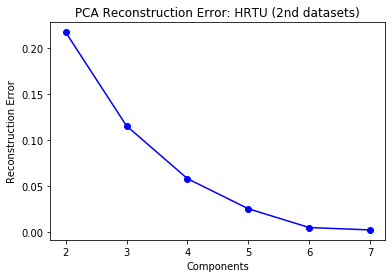

In [445]:
reconstruct_error_list = []
eigen_variance = []
for i in range(2, 8):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_reconstruct = pca.inverse_transform(X_train_pca)
    reconstruct_error =  ((X_train - X_reconstruct) ** 2).mean()
    reconstruct_error_list.append(reconstruct_error)
    variance = np.mean(pca.explained_variance_)
    eigen_variance.append(variance)
#     print("Components", i, " KURTOSIS", kurtosis_dat)


fig, ax = plt.subplots()
ax.plot( range(2, 8), reconstruct_error_list, "b-o")
# ax.plot(range_loop , aic_score, "g-", label='AIC Score')
ax.set_xlabel('Components')
ax.set_ylabel('Reconstruction Error')
ax.set_title('PCA Reconstruction Error: HRTU (2nd datasets)')
# ax.legend()
plt.show(fig)

In [420]:
# let say we use 5 Components!! 
final_pca = PCA(n_components=3)
final_pca.fit(X_train)
X_train_pca = final_pca.transform(X_train)

No handles with labels found to put in legend.


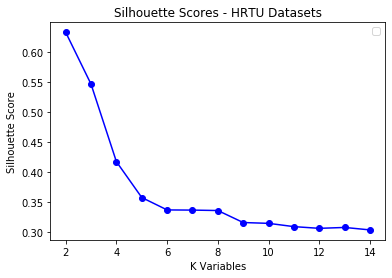

No handles with labels found to put in legend.


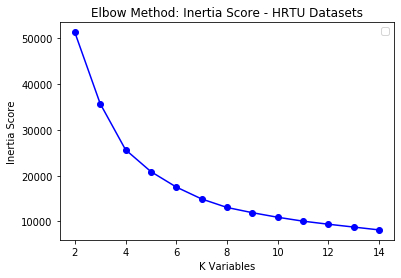

In [421]:
# Perform clustering again!!
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# k = 5
kmean_clfs_n = []
range_loop = range(2, 15)
for i in range_loop:
#     print("K", i)
    kmean = KMeans(n_clusters=i , random_state=random_state)
    kmean.fit(X_train_pca)
    kmean_clfs_n.append(kmean)

silhouette = [silhouette_score(X_train_pca, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , silhouette, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores - HRTU Datasets')
ax.legend()
plt.show(fig)

fig, ax = plt.subplots()
ax.plot(range_loop , inertia, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Inertia Score')
ax.set_title('Elbow Method: Inertia Score - HRTU Datasets')
ax.legend()
plt.show(fig)
# Find meaningful part of Clustering via PCA!!

In [422]:
# from silhouette score, it is k = 2!!
kmean = KMeans(n_clusters=2, random_state=random_state)
kmean.fit(X_train_pca)

pca_cluster = kmean.predict(X_train_pca)
get_all_cluster_metric_score(pca_cluster, y_train)

SCORE
Homogenity: 0.43667591005245904
V Measure: 0.4053050250633043
Completeness: 0.37813941371528315
Adjusted RandIndex: 0.6077123454092836


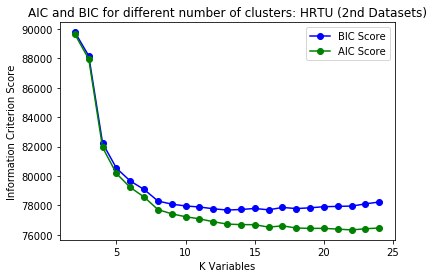

In [423]:
gm_clfs_n = []
range_loop = range(2, 25)
for i in range_loop:
#     print("K", i)
    gm = GaussianMixture(n_components=i , random_state=random_state)
    gm.fit(X_train_pca)
    gm_clfs_n.append(gm)


bic_score = [i.bic(X_train_pca) for i in gm_clfs_n]
aic_score = [i.aic(X_train_pca) for i in gm_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , bic_score, "b-o", label='BIC Score')
ax.plot(range_loop , aic_score, "g-o", label='AIC Score')
ax.set_xlabel('K Variables')
ax.set_ylabel('Information Criterion Score')
ax.set_title('AIC and BIC for different number of clusters: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [424]:
gm = GaussianMixture(n_components=23, random_state=random_state)
gm.fit(X_train_pca)

y_pred_pca_gmm = gm.predict(X_train_pca)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_pca_gmm, y_train)

SCORE
Homogenity: 0.6976901104958187
V Measure: 0.14009522102008912
Completeness: 0.0778652260129433
Adjusted RandIndex: 0.028855893624333214


## ICA

In [447]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
kurtosis_ica = []
for i in range(2, 8):
    ica = FastICA(n_components=i, random_state=random_state)
    X_train_ica = ica.fit_transform(X_train)
    kurtosis_dat = np.mean(kurtosis(X_train_ica))
    kurtosis_ica.append(kurtosis_dat)
    print("Components", i, " KURTOSIS", kurtosis_dat)

Components 2  KURTOSIS 7.360192187245708
Components 3  KURTOSIS 10.829301499778047
Components 4  KURTOSIS 10.381785650224476
Components 5  KURTOSIS 12.121092988709306
Components 6  KURTOSIS 15.376714038266568
Components 7  KURTOSIS 15.780692784965023


No handles with labels found to put in legend.


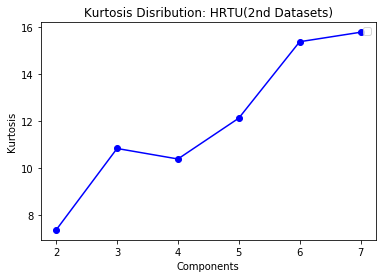

In [448]:
fig, ax = plt.subplots()
ax.plot(range(2, 8) , kurtosis_ica, "b-o")
ax.set_xlabel('Components')
ax.set_ylabel('Kurtosis')
ax.set_title('Kurtosis Disribution: HRTU(2nd Datasets)')
ax.legend()
plt.show(fig)
# Maximize Variance are 6 components!!, since 8 have the most kurtosis but it actually the same numbers as the original features!!

In [24]:
# Silhouette_schore
# So we choose ICA components according to Maxium Kurtosis, which is 8
ica_final = FastICA(n_components=6, random_state=random_state)
X_train_ica = ica_final.fit_transform(X_train)

In [252]:
# kurtosis_dat = np.mean(kurtosis(X_train_ica))
kmean_clfs_n = []
range_loop = range(2, 21)
for i in range_loop:
#     print("K", i)
    kmean = KMeans( n_clusters=i , random_state=random_state)
    kmean.fit(X_train_ica)
    kmean_clfs_n.append(kmean)

# Silhouette_schore
silhouette = [silhouette_score(X_train_ica, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]

# test_score_n = [i.score(X_test, y_test) for i in knn_clfs_n]
# print("Silhouette Score", silhouette)
# print("Test Score", test_score_n)

No handles with labels found to put in legend.


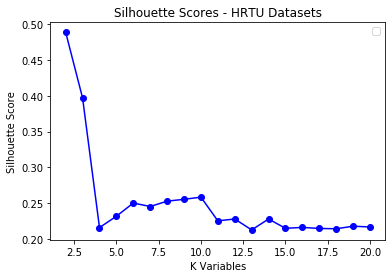

In [253]:
silhouette = [silhouette_score(X_train_ica, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , silhouette, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores - HRTU Datasets')
ax.legend()
plt.show(fig)

No handles with labels found to put in legend.


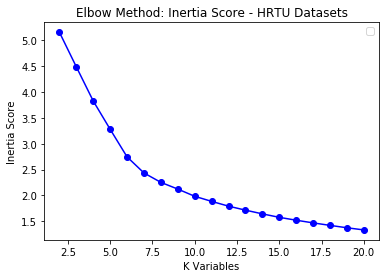

In [254]:
# Elbow Method
fig, ax = plt.subplots()
ax.plot(range_loop , inertia, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Inertia Score')
ax.set_title('Elbow Method: Inertia Score - HRTU Datasets')
ax.legend()
plt.show(fig)

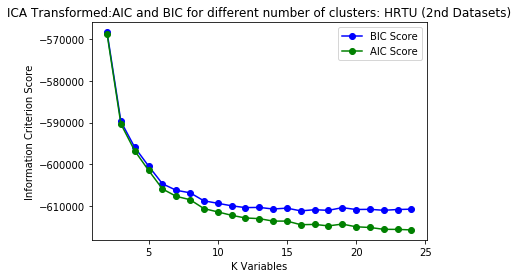

In [260]:
gm_clfs_n = []
range_loop = range(2, 25)
for i in range_loop:
#     print("K", i)
    gm = GaussianMixture(n_components=i , random_state=random_state)
    gm.fit(X_train_ica)
    gm_clfs_n.append(gm)


bic_score = [i.bic(X_train_ica) for i in gm_clfs_n]
aic_score = [i.aic(X_train_ica) for i in gm_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , bic_score, "b-o", label='BIC Score')
ax.plot(range_loop , aic_score, "g-o", label='AIC Score')
ax.set_xlabel('K Variables')
ax.set_ylabel('Information Criterion Score')
ax.set_title('ICA Transformed:AIC and BIC for different number of clusters: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [261]:
kmean = KMeans( init='k-means++', n_clusters=2 , random_state=random_state)
kmean.fit(X_train_ica)

ica_cluster = kmean.predict(X_train_ica)
get_all_cluster_metric_score(ica_cluster, y_train)
# import seaborn as sns

SCORE
Homogenity: 0.31178715038126326
V Measure: 0.28423245053035506
Completeness: 0.26115265693315043
Adjusted RandIndex: 0.48633369792610004


In [330]:
gm = GaussianMixture(n_components=23, random_state=random_state)
gm.fit(X_train_ica)

y_pred_ica_gmm = gm.predict(X_train_ica)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_ica_gmm, y_train)

SCORE
Homogenity: 0.7117419721746939
V Measure: 0.15428115472672926
Completeness: 0.08651759532236614
Adjusted RandIndex: 0.047005668860981474


## Randomized Projection

In [37]:
from sklearn.random_projection import GaussianRandomProjection, johnson_lindenstrauss_min_dim, SparseRandomProjection
rand_pj = GaussianRandomProjection(n_components=30)
rand_pj.fit(X_train)
X_train_rand_pj  = rand_pj.transform(X_train)

def reconstruct_rp(X_transformed, rand_proj,X_train):
    return (X_transformed.dot(rand_proj.components_) + np.mean(X_train, axis=0))

X_reconstructed = reconstruct_rp(X_train_rand_pj, rand_pj, X_train)

reconstruction_error = np.mean((X_train - X_reconstructed)**2)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


In [183]:
def run_randomized_projection():
    contruct_err = []
    for i in range(2, 9):
        rand_pj = GaussianRandomProjection(n_components=i)
        rand_pj.fit(X_train)
        X_trainsformed = rand_pj.transform(X_train)
        X_reconstructed = reconstruct_rp(X_trainsformed, rand_pj, X_train)
        error = np.mean((X_train - X_reconstructed)**2)
        contruct_err.append(error)
    return contruct_err

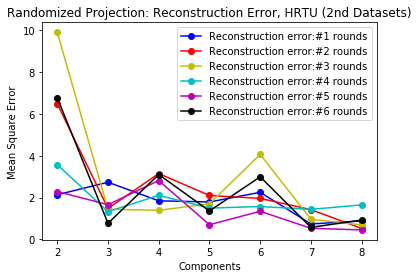

In [185]:
fig, ax = plt.subplots()
color = ['b-o', 'r-o', 'y-o', 'c-o', 'm-o', 'k-o']
for i in range(0, 6):
    new_err = run_randomized_projection()
    ax.plot(range(2, 9) , new_err, color[i], label=f'Reconstruction error:#{i+1} rounds')
ax.set_xlabel('Components')
ax.set_ylabel('Mean Square Error')
ax.set_title('Randomized Projection: Reconstruction Error, HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

No handles with labels found to put in legend.


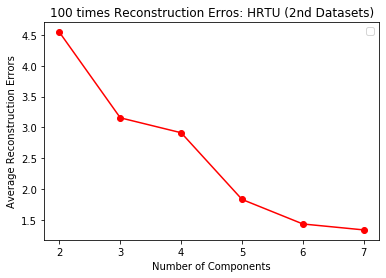

In [176]:
# 100 times letsay
error_list = []
for i in range(2, 8):
    contruct_err = []
    for j in range(1, 101):
        rand_pj = GaussianRandomProjection(n_components=i)
        rand_pj.fit(X_train)
        X_trainsformed = rand_pj.transform(X_train)
        X_reconstructed = reconstruct_rp(X_trainsformed, rand_pj, X_train)
        error = np.mean((X_train - X_reconstructed)**2)
        contruct_err.append(error)
    error_list.append(np.mean(contruct_err))
    
fig, ax = plt.subplots()
ax.plot(range(2, 8) , error_list, "r-o")
ax.set_xlabel('Number of Components')
ax.set_ylabel('Average Reconstruction Errors')
ax.set_title('100 times Reconstruction Erros: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [267]:
# Let Try 6!!
# let say we use 5 Components!!
final_rpj = GaussianRandomProjection(n_components=6)
final_rpj.fit(X_train)
X_train_rpj = final_rpj.transform(X_train)

In [268]:
# kurtosis_dat = np.mean(kurtosis(X_train_ica))
kmean_clfs_n = []
range_loop = range(2, 15)
for i in range_loop:
#     print("K", i)
    kmean = KMeans(n_clusters=i , random_state=random_state)
    kmean.fit(X_train_rpj)
    kmean_clfs_n.append(kmean)

# Silhouette_schore
silhouette = [silhouette_score(X_train_rpj, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]

No handles with labels found to put in legend.


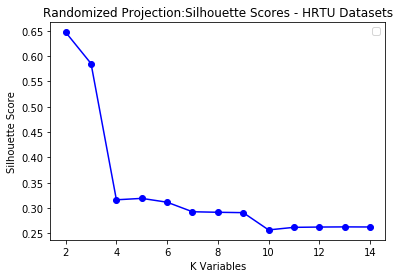

In [269]:
# Silhouette_schore
silhouette = [silhouette_score(X_train_rpj, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , silhouette, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Silhouette Score')
ax.set_title('Randomized Projection:Silhouette Scores - HRTU Datasets')
ax.legend()
plt.show(fig)

No handles with labels found to put in legend.


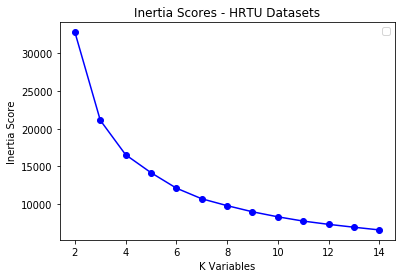

In [270]:
fig, ax = plt.subplots()
ax.plot(range_loop , inertia, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Inertia Score')
ax.set_title('Inertia Scores - HRTU Datasets')
ax.legend()
plt.show(fig)

In [281]:
# from silhouette score, it is k = 2!!
kmean = KMeans(n_clusters=2, random_state=random_state)
kmean.fit(X_train_rpj)

rpj_cluster = kmean.predict(X_train_rpj)
get_all_cluster_metric_score(rpj_cluster, y_train)

SCORE
Homogenity: 0.36541882482708116
V Measure: 0.33040244101929944
Completeness: 0.30151012976324953
Adjusted RandIndex: 0.5310594065096794


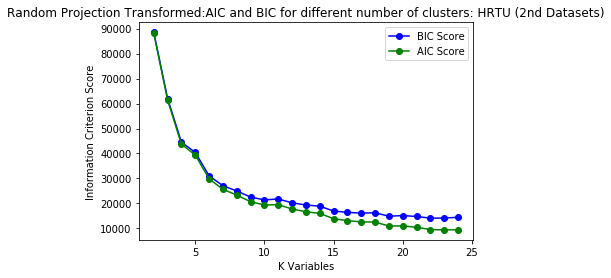

In [302]:
gm_clfs_n = []
range_loop = range(2, 25)
for i in range_loop:
#     print("K", i)
    gm = GaussianMixture(n_components=i , random_state=random_state)
    gm.fit(X_train_rpj)
    gm_clfs_n.append(gm)


bic_score = [i.bic(X_train_rpj) for i in gm_clfs_n]
aic_score = [i.aic(X_train_rpj) for i in gm_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , bic_score, "b-o", label='BIC Score')
ax.plot(range_loop , aic_score, "g-o", label='AIC Score')
ax.set_xlabel('K Variables')
ax.set_ylabel('Information Criterion Score')
ax.set_title('Random Projection Transformed:AIC and BIC for different number of clusters: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [333]:
gm = GaussianMixture(n_components=23, random_state=random_state)
gm.fit(X_train_rpj)

y_pred_rpj_gmm = gm.predict(X_train_rpj)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_rpj_gmm, y_train)

SCORE
Homogenity: 0.6997328178700529
V Measure: 0.14272817659341497
Completeness: 0.07946893638785651
Adjusted RandIndex: 0.03156260682665029


## Neural Networks and Feature Transformation

In [425]:
def run_neural_networks(X_train, y_train, X_test, y_test):
    param_grid = [{
    'activation': ['relu', 'logistic', 'tanh'],
    'hidden_layer_sizes':[(10,), (10,2), (10,4), (10, 8), (10, 16), (10, 32)]
    }]

    ann_clf = MLPClassifier(solver='adam', max_iter=300, random_state=random_state)
    ann_grid_clf = GridSearchCV(ann_clf, param_grid, cv=5,
                               scoring='f1', return_train_score=True)
    
    ann_grid_clf.fit(X_train, y_train)
    ann_grid_clf_best = ann_grid_clf.best_estimator_
    start_time = time.time()
    ann_grid_clf_best.fit(X_train, y_train)
    stop_time = time.time()
    print(f"Fit time: {stop_time - start_time} seconds")
    pred_ann_train = ann_grid_clf_best.predict(X_train)
    pred_ann = ann_grid_clf_best.predict(X_test)
    print("Train Performance:", get_all_metrics_score(pred_ann_train, y_train))
    print("Test Performance:", get_all_metrics_score(pred_ann, y_test))
    print("Best Model:", ann_grid_clf_best)
    return ann_grid_clf.best_estimator_

In [442]:
nn_original = run_neural_networks(X_train, y_train, X_test, y_test)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fit time: 6.680138349533081 seconds
SCORE
Accuracy: 0.9805687599032608
Precision: 0.8463611859838275
Recall: 0.9382470119521913
F1 Score: 0.8899385923476618
Train Performance: None
SCORE
Accuracy: 0.9781615033011681
Precision: 0.8307984790874525
Recall: 0.9161425576519916
F1 Score: 0.8713858424725823
Test Performance: None
Best Model: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [427]:
# let say we use 3 Components!! (Retain >=90% Variances)
final_pca = PCA(n_components=3, random_state = random_state)
final_pca.fit(X_train)
X_train_pca = final_pca.transform(X_train)
X_test_pca = final_pca.transform(X_test)

pca_3 = run_neural_networks(X_train_pca, y_train, X_test_pca, y_test)

Fit time: 9.214362144470215 seconds
SCORE
Accuracy: 0.979151029939121
Precision: 0.825696316262354
Recall: 0.9425641025641026
F1 Score: 0.8802681992337165
Train Performance: None
SCORE
Accuracy: 0.97866937531742
Precision: 0.8193916349809885
Recall: 0.9329004329004329
F1 Score: 0.8724696356275303
Test Performance: None
Best Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [428]:
# So we choose ICA components according to Maxium Kurtosis, which is 8
final_ica = FastICA(n_components=6, random_state=random_state)
final_ica.fit(X_train)
X_train_ica = final_ica.transform(X_train)
X_test_ica = final_ica.transform(X_test)

ica_6 = run_neural_networks(X_train_ica, y_train, X_test_ica, y_test)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum ite

Fit time: 12.218329906463623 seconds
SCORE
Accuracy: 0.9782336752564423
Precision: 0.8149146451033243
Recall: 0.9428274428274428
F1 Score: 0.8742168674698795
Train Performance: None
SCORE
Accuracy: 0.9776536312849162
Precision: 0.8060836501901141
Recall: 0.933920704845815
F1 Score: 0.8653061224489796
Test Performance: None
Best Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [429]:
final_rpj = GaussianRandomProjection(n_components=6)
final_rpj.fit(X_train)
X_train_rpj = final_rpj.transform(X_train)
X_test_rpj = final_rpj.transform(X_test)

rpj_model = run_neural_networks(X_train_rpj, y_train, X_test_rpj, y_test)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fit time: 6.807796478271484 seconds
SCORE
Accuracy: 0.9816529063464264
Precision: 0.8589398023360287
Recall: 0.9381746810598626
F1 Score: 0.8968105065666041
Train Performance: None
SCORE
Accuracy: 0.9800237006940917
Precision: 0.8479087452471483
Recall: 0.9214876033057852
F1 Score: 0.8831683168316831
Test Performance: None
Best Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


# Neural Network with clusters

In [430]:
def combine_data_w_cluser(feature_array, cluster_array):
    data_w_cluster = np.c_[feature_array, cluster_array]
    df_data_w_cluster = pd.DataFrame(data_w_cluster)
    feature_array_new = df_data_w_cluster.drop(df_data_w_cluster.columns[-1])
    job_encoder = OneHotEncoder()
    cluster_one_hot = job_encoder.fit_transform(df_data_w_cluster[[df_data_w_cluster.columns[-1]]])
#     feature_array_new = feature_array.drop()
    final_feature_with_cluster = np.concatenate((feature_array ,cluster_one_hot.toarray()),axis=1)
    return final_feature_with_cluster

In [438]:
fin_kmeans = KMeans(n_clusters=2, random_state=random_state)
fin_kmeans.fit(X_train)

y_pred_kmeans_train = fin_kmeans.predict(X_train)
y_pred_kmeans_test = fin_kmeans.predict(X_test)

X_train_kmean = combine_data_w_cluser(X_train, y_pred_kmeans_train)
X_test_kmean = combine_data_w_cluser(X_test, y_pred_kmeans_test)

optimal_model_kmean = run_neural_networks(X_train_kmean, y_train, X_test_kmean, y_test)

Fit time: 7.450078964233398 seconds
SCORE
Accuracy: 0.9810691351847218
Precision: 0.862533692722372
Recall: 0.9284332688588007
F1 Score: 0.8942710759198882
Train Performance: None
SCORE
Accuracy: 0.978500084645336
Precision: 0.8422053231939164
Recall: 0.9096509240246407
F1 Score: 0.8746298124383022
Test Performance: None
Best Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [313]:
gm = GaussianMixture(n_components=21, random_state=random_state)
gm.fit(X_train)

y_pred_gmm_train = gm.predict(X_train)
y_pred_gmm_test = gm.predict(X_test)

X_train_gmm =  combine_data_w_cluser(X_train, y_pred_gmm_train)
X_test_gmm = combine_data_w_cluser(X_test, y_pred_gmm_test)
run_neural_networks(X_train_gmm, y_train, X_test_gmm, y_test)

Fit time: 9.3611741065979 seconds
SCORE
Accuracy: 0.9809023434242349
Precision: 0.8652291105121294
Recall: 0.9241842610364683
F1 Score: 0.8937354988399071
Train Performance: None
SCORE
Accuracy: 0.9795158286778398
Precision: 0.8498098859315589
Recall: 0.9141104294478528
F1 Score: 0.8807881773399016
Test Performance: None
Best Model: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## Factor Analysis

No handles with labels found to put in legend.


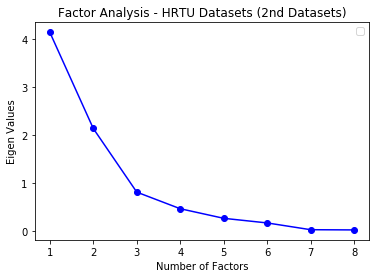

In [389]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(X_train)
ev, v = fa.get_eigenvalues()
# fa.get_eigenvalues()
fig, ax = plt.subplots()
ax.plot(range(1, ev.shape[0]+1) , ev, "b-o")
ax.set_xlabel('Number of Factors')
ax.set_ylabel('Eigen Values')
ax.set_title('Factor Analysis - HRTU Datasets (2nd Datasets)')
ax.legend()
plt.show(fig)

In [390]:
fa = FactorAnalyzer(n_factors=3)
fa.fit(X_train)
X_train_fa = fa.transform(X_train)

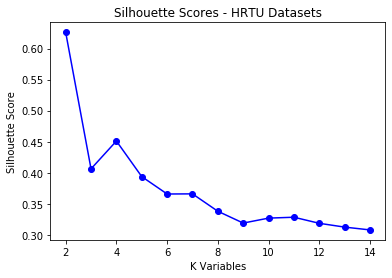

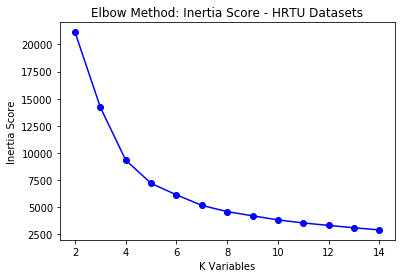

In [391]:
# Perform clustering again!!
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# k = 5
kmean_clfs_n = []
range_loop = range(2, 15)
for i in range_loop:
#     print("K", i)
    kmean = KMeans(n_clusters=i , random_state=random_state)
    kmean.fit(X_train_fa)
    kmean_clfs_n.append(kmean)

    
silhouette = [silhouette_score(X_train_fa, i.labels_) for i in kmean_clfs_n]
inertia = [ i.inertia_ for i in kmean_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , silhouette, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores - HRTU Datasets')
# ax.legend()
plt.show(fig)

fig, ax = plt.subplots()
ax.plot(range_loop , inertia, "b-o")
ax.set_xlabel('K Variables')
ax.set_ylabel('Inertia Score')
ax.set_title('Elbow Method: Inertia Score - HRTU Datasets')
# ax.legend()
plt.show(fig)

In [394]:
# from silhouette score, it is k = 2!!
kmean = KMeans(n_clusters=2, random_state=random_state)
kmean.fit(X_train_fa)

fa_cluster = kmean.predict(X_train_fa)
get_all_cluster_metric_score(fa_cluster, y_train)

SCORE
Homogenity: 0.47103785406324483
V Measure: 0.427126911843268
Completeness: 0.39070475631650503
Adjusted RandIndex: 0.6205051497070339


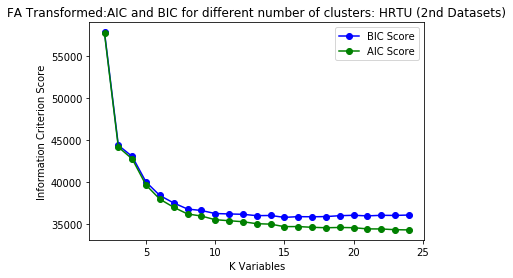

In [408]:
# GMM
gm_clfs_n = []
range_loop = range(2, 25)
for i in range_loop:
#     print("K", i)
    gm = GaussianMixture(n_components=i , random_state=random_state)
    gm.fit(X_train_fa)
    gm_clfs_n.append(gm)


bic_score = [i.bic(X_train_fa) for i in gm_clfs_n]
aic_score = [i.aic(X_train_fa) for i in gm_clfs_n]
fig, ax = plt.subplots()
ax.plot(range_loop , bic_score, "b-o", label='BIC Score')
ax.plot(range_loop , aic_score, "g-o", label='AIC Score')
ax.set_xlabel('K Variables')
ax.set_ylabel('Information Criterion Score')
ax.set_title('FA Transformed:AIC and BIC for different number of clusters: HRTU (2nd Datasets)')
ax.legend()
plt.show(fig)

In [413]:
gm = GaussianMixture(n_components=23, random_state=random_state)
gm.fit(X_train_fa)

y_pred_fa_gmm = gm.predict(X_train_fa)
# y_pred_gmm_prob = gm.predict_proba(X_train)
get_all_cluster_metric_score(y_pred_fa_gmm, y_train)

SCORE
Homogenity: 0.7249063205747446
V Measure: 0.14842330759926692
Completeness: 0.08267548459599078
Adjusted RandIndex: 0.0316325741493158


In [439]:
final_fa = FactorAnalyzer(n_factors=3)
final_fa.fit(X_train)
# X_train_fa = fa.transform(X_train)
X_train_fa = final_rpj.transform(X_train)
X_test_fa = final_rpj.transform(X_test)

run_neural_networks(X_train_fa, y_train, X_test_fa, y_test)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fit time: 7.779202938079834 seconds
SCORE
Accuracy: 0.9816529063464264
Precision: 0.8589398023360287
Recall: 0.9381746810598626
F1 Score: 0.8968105065666041
Train Performance: None
SCORE
Accuracy: 0.9800237006940917
Precision: 0.8479087452471483
Recall: 0.9214876033057852
F1 Score: 0.8831683168316831
Test Performance: None
Best Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)